# Weather Station Data - cleaned final version 
## Level 1 QC

In [4]:
#import external libraries
import pandas as pd
import os
#pd.options.mode.chained_assignment =  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import LVL1
import CleanWxData as wx
import settings
from settings import base_path
Glacier='Sperry'
Station='2440'

data_columns, general_data_columns, out_date_format, precip_columns, precip_gage_change, primary_temp_column, temp_columns, timezone, wind_col, wind_dir_columns = settings.get_settings(settings.Glacier, settings.Station)

In [5]:
#Do you want to display plots (slow for large datasets)
show_plots=True #True= show plots
frac=0.1 #fraction of data to show in plots (0.3 = 30%)

** Define Location-Specific Baseline Settings **

In [6]:
#path to level 0 data
file_label='_15min_all'
pth=base_path + 'Data/'+Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+ Station+ file_label+'_LVL0' +".csv"
    
#time format and column
local_time_column_name='local_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_pth=base_path +'Data/' +Glacier+ r"/AllYears/Wx/LVL1/" + Glacier.lower()+Station+file_label+"_LVL1.csv"

### Data import
- read in data 
- set timezone
- set time as index

In [7]:
#read in level0 CSV
if (Glacier + Station == 'Wolverine990') | (Glacier + Station =='Gulkana1480')| (Glacier+Station=='Gulkana1725')| (Glacier=='SouthCascade'):
    pth=base_path +r"Data/" + Glacier + r'/AllYears/Wx/LVL0/telemetry_added/' + Glacier.lower() + Station+ file_label + '_LVL0.csv'
    
dat=pd.read_csv(pth)
print("read data from: "+ pth)

#Set local time to dataframe index
dat['local_time']=pd.to_datetime(dat[local_time_column_name], format=date_format)
dat=dat.set_index('local_time')
#dat=dat.tz_localize(timezone, ambiguous='infer')

read data from: Q:/Project Data/GlacierData/Benchmark_Program/Data/Sperry/AllYears/Wx/LVL0/sperry2440_15min_all_LVL0.csv


In [8]:
#Determine if dataset contains precip data (may want to revisit this later)
precip_present=len(precip_columns)>0
temp_present=len(temp_columns)>0
wind_present=len(wind_col)>0

In [9]:
dat=dat.sort_index() #ensure data is sorted by time

In [10]:
dat.head(1)

,UTC_time,Tpassive1,WindSpeed,WindDir,RelHum,SWup_incoming,SWdn_outgoing,LWup_incoming,LWdn_outgoing
local_time,,,,,,,,,
2006-06-28 14:00:00,2006/06/28 20:00,13.48,4.054,245.9,51.93,NaN,NaN,NaN,NaN


Station-specific Data Adjustments

In [11]:
# Wolverine990 and Gulkana 1480: Prior to April 2014, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    
if Glacier+Station=="Gulkana1480":
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [12]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=base_path+ r"Metadata\weather"
try:
    bad_sensor_dates_dat=pd.read_excel(os.path.join(pth_bad_sensor_dates, Glacier+"_SensorLog.xlsx"),sheetname=Glacier+Station)
    bad_sensor_dates_dat
except:
    print("no manual QC log exists for this site")
    bad_sensor_dates_dat=pd.DataFrame()
    

no manual QC log exists for this site


In [13]:
#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)
print("Removed")

Removed


In [14]:
dat.tail(1)

,UTC_time,Tpassive1,WindSpeed,WindDir,RelHum,SWup_incoming,SWdn_outgoing,LWup_incoming,LWdn_outgoing
local_time,,,,,,,,,
2018-03-28 18:00:00,2018/03/29 00:00,-5.564,6.55361,308.6,98.7,214.8,249.8,-20.15,-8.54


In [15]:
# # #Time subset for trouble-shooting
# dat=dat['2015-04':]
# for precip_col in precip_columns:
#     if pd.notnull((dat[precip_col][0])):
#         dat[precip_col]=dat[precip_col]-dat[precip_col][0]
#     else:
#         print("first val in "+ precip_col + " is null")

** Set hard-coded cutoff values** (station specific)

In [16]:
#Generic Settings
low_temp_cutoff=-40.0 #deg. C
high_temp_cutoff=30.0

obvious_error_precip_cutoff=60. #if 60 mm (6 cm) in 2 hrs, obviously an error. (7/2016 has a drain of only 24 cm)

#Glacier-specific settings; can also adjust generic settings given above here
if (Glacier+Station=="Wolverine990"):    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was removed
    TPG_born='2012/10/02 00:00:00' #time at which instrument was removed
        
if (Glacier + Station== "Gulkana1480"):    
    Stage_dies='2015/09/25 11:30:00' #time at which instrument was removed
    TPG_born='2011/07/15 18:30:00' #time at which instrument was removed
    
if (Glacier + Station== "Gulkana1725"):    
    TPG_born='2014-08-26 16:00:00'
    
if (Glacier + Station== "Wolverine1420"):    
    TPG_born='2017-07-23 13:30:00'
    
if (Glacier + Station== "Wolverine1420") | (Glacier+Station=="Gulkana1920") : #these are the 2 ridgetop JWS sites
    print('normal settings good')

In [17]:
#Convert units in precipitation columns from meters to mm
if precip_present:
    for precip_col in precip_columns:
        dat.loc[:,precip_col]=dat[precip_col]*1000


In [18]:
if precip_present:
    #Set gages to NAN, when not installed (single gauge style does not cover period of record)
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all():
            print("no data in "+ precip_col)
            continue
        if 'TPG' in precip_col.upper(): #this is the current precip gage
            dat.loc[:TPG_born, precip_col]=np.nan
        if 'stage' in precip_col.lower(): #this is old precip gage
            dat.loc[Stage_dies:, precip_col]=np.nan

** Adjust for size of stage gage orifice (x5) **
- this is a legacy issue; gage orifice used is bigger than instrument design. Thus, precip recorded on logger is 1/5 of true

In [19]:
if precip_present:
    if 'StageCumulative' in dat.columns:
        dat['StageCumulative']=dat.StageCumulative*5 #legacy issue; see comment above

In [20]:
#Save unaltered data for later comparrison with edits
dat_original=dat.copy() 

** Clean Temperature Data**

In [21]:
if temp_present:
    #Temperature
    for temp_col in temp_columns:
        temps=dat.loc[:,temp_col]
        dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
dat.Tpassive1.first_valid_index()

Timestamp('2006-06-28 14:00:00')

#### Plot temperature data, before and after

<IPython.core.display.Javascript object>


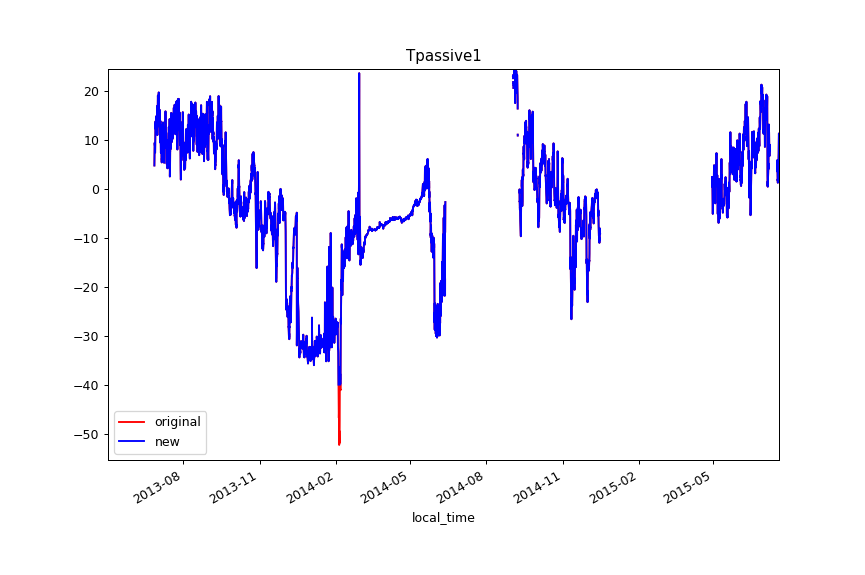

In [23]:
if show_plots:
    plt.figure()
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat, data_col_name=primary_temp_column)

,Date,[C]
0,6/28/2006,10.3
1,6/29/2006,8.4
2,6/30/2006,10.1
3,7/1/2006,11.3
4,7/2/2006,11.8


** Clean Wind Speed Data **

In [28]:
#Remove wind speed data where problems with riming (or other falls to 0) are present
if wind_present:
    dat=wx.clean_wind_speed_data(dat, wind_col)

<IPython.core.display.Javascript object>


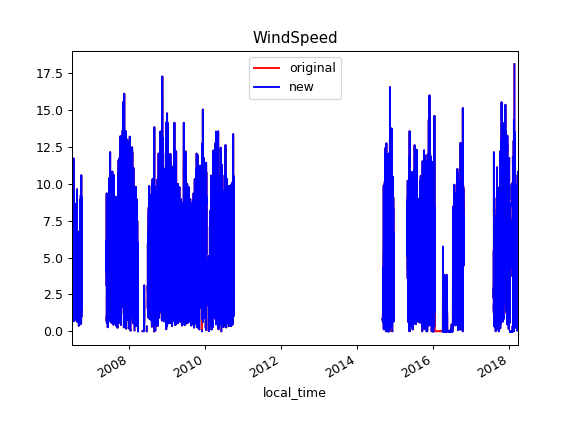

In [29]:
if show_plots and wind_present:
    plt.figure()
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat, data_col_name=wind_col)

#### Clean Wind Direction Data

In [30]:
if wind_present:
    if wind_dir_columns[0] in dat.columns:
        for col in wind_dir_columns:
            dat.loc[dat[col]>360, col]=np.nan #Nonsensical; at wolverine990, this is only 3 days; results from mis-pogramming of logger

In [31]:
#Correct direction during periods when sensor not aligned to true north
if Glacier + Station == 'Wolverine990': 
    og_dir=dat.loc['2016-09-09 11': '2017-07-23', 'VecAvgWindDir'].copy()
    adj_dir=og_dir-215 # this is 360-145, as indicated by Louis's notes
    adj_dir[adj_dir<0]=adj_dir[adj_dir<0]+360 #convert negative angles to unit circle
    dat.loc['2016-09-09 11': '2017-07-23', 'VecAvgWindDir']=adj_dir

    og_dir=dat.loc['2017-07-23': '2017-09-10', 'VecAvgWindDir'].copy()
    adj_dir=og_dir-335
    adj_dir[adj_dir<0]=adj_dir[adj_dir<0]+360 #convert negative angles to unit circle
    dat.loc['2017-07-23': '2017-09-10', 'VecAvgWindDir']=adj_dir

** Plot original precipitation data**

In [32]:
#Precip
if precip_present:
    dat[precip_columns].plot()

** Remove Gauge Drain and Fill Maintenance **

In [33]:
if precip_present:
    #Early stage gage measurements had HUGE thermal flctuations; on the order of 15 cm precip in a day
    if Glacier + Station=="Wolverine990":
        end_stage_extra_noise_date='2007-09-18 00'
        #Consider finding a way to folter these huge daily swings into a useful product; currently, option to NAN and trust historical data processing instead
        dat.loc[:end_stage_extra_noise_date, 'StageCumulative']=pd.np.nan #LVL1.precip_remove_drain_and_fill(dat.StageCumulative[:end_stage_extra_noise_date], obvious_error_precip_cutoff=200, n_window=4)

In [34]:
if precip_present:
    #Remove unrealistically large instantaneous jumps; create continuous timreseries
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all():
            print("no data in "+ precip_col)
            continue    
        print(precip_col)
        if dat[precip_col].isnull().all(): #if no values in column, skip
            continue
        dat.loc[:,precip_col]=LVL1.precip_remove_drain_and_fill(dat[precip_col], obvious_error_precip_cutoff=obvious_error_precip_cutoff, n_window=4)
    dat_step0=dat[precip_columns].copy() #save for plotting

In [35]:
if precip_present:
    #Plot
    if not dat[precip_columns[0]].isnull().all() and show_plots:
        plt.figure()
        LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[0], label_old="original", label_new="drain and fill removed")

In [36]:
if precip_present and len(precip_columns)>1:
    #Plot stage-type precip gage
    if not dat[precip_columns[1]].isnull().all() and show_plots :
        plt.figure()
        ax=LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[1], label_old="original", label_new="drain and fill removed")
else:
    print('no secondary precip record')

no secondary precip record


<IPython.core.display.Javascript object>


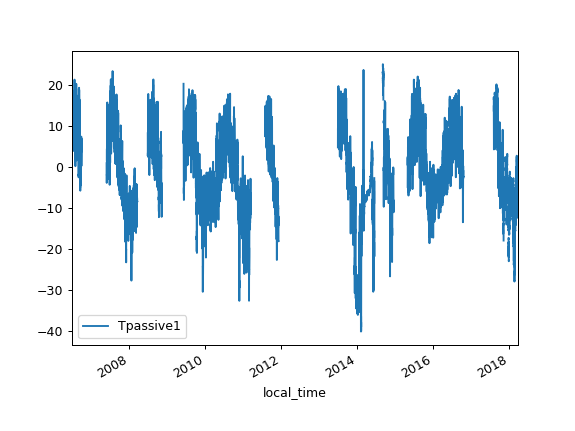

In [37]:
dat[temp_columns].plot()

In [38]:
if precip_present:
    #Strip high-amplitude noise related to wind with hampel filter
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all():
            continue
        dat.loc[:,precip_col]=LVL1.hampel(dat_step0[precip_col], t0=2)
    dat_step1=dat[precip_columns].copy() #save for plotting

In [39]:
if precip_present:
    #Run filter on daily window, to remove sensor malfunctions
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all():
            continue
        dat.loc[:,precip_col]=LVL1.basic_median_outlier_strip(dat_step1[precip_col],k=96, threshold=10) #remove values > 10 mm (1cm)from daily median val
    dat_step2=dat[precip_columns].copy() #save for plotting

In [40]:
#Plot results
if precip_present:
    if show_plots and not dat_original[precip_columns[0]].isnull().all():
        plt.figure()
        LVL1.plot_comparrison(df_old=dat_step0, df_new=dat_step2, data_col_name=precip_columns[0], label_old="original", label_new="after hampel outlier filter")

In [41]:
if precip_present and len(precip_columns)>1:
    #Plot results
    if show_plots and not dat_original[precip_columns[1]].isnull().all():
        plt.figure()
        LVL1.plot_comparrison(df_old=dat_step0, df_new=dat_step2, data_col_name=precip_columns[1], label_old="original", label_new="after hampel outlier filter")

**Smooth Data with method from Nayak (2010): **

In [42]:
if precip_present:
    #Smooth Incremental Precip Data, if there are any decreases in the record
    dx=dat[precip_col]-dat[precip_col].shift(1)
    if dx.min()<0:
        for precip_col in precip_columns:
            #Smooth this data with method from Nayak 2010
            if dat[precip_col].isnull().all(): #if no values in column, skip
                continue
            print ("smoothing "+ precip_col)
            precip_interpolated=dat_step2[precip_col].copy()
            dat[precip_col]=LVL1.smooth_precip_Nayak2010(precip_interpolated)
        dat_step3=dat[precip_columns].copy() #save for plotting
    else:
        print("monotonically increasing series")
        dat_step3=dat[precip_columns].copy() #save for plotting

In [43]:
if precip_present:
    #Plot
    if show_plots and not dat_original[precip_columns[0]].isnull().all():
        plt.figure()
        LVL1.plot_comparrison(df_old=dat_step2, df_new=dat_step3, data_col_name=precip_columns[0], label_old="original", label_new="after smoothing")

In [44]:
if precip_present and len(precip_columns)>1:
    if show_plots and not dat_original[precip_columns[1]].isnull().all():
        plt.figure()
        LVL1.plot_comparrison(df_old=dat_step2.sample(frac=frac), df_new=dat_step3.sample(frac=frac), data_col_name=precip_columns[1], label_old="original", label_new="after smoothing")

In [45]:
if precip_present:
    #Final Comparrison Plot
    if show_plots and not dat_original[precip_columns[0]].isnull().all():
        plt.figure()
        frac=0.1
        ax=dat_original[precip_columns[0]].sample(frac=frac).plot(color='black', label='original')
        dat_step0[precip_columns[0]].sample(frac=frac).plot(color='blue', ax=ax, label='fills removed')
        dat_step3[precip_columns[0]].sample(frac=frac).plot(color='red', ax=ax, label='final')
        plt.legend()

Final Steps

In [46]:
if precip_present:
    #Set no-data values before TPG installed, and after rocket removed to NAN (not 0)
    for precip_col in precip_columns:
        if dat[precip_col].isnull().all(): #if no values in column, skip
            continue
        if 'TPG' in precip_col.upper():
            dat.loc[:TPG_born, precip_col]=np.nan
        if 'stage' in precip_col.lower():
            dat.loc[Stage_dies:, precip_col]=np.nan

In [47]:
dat.head(1)

,UTC_time,Tpassive1,WindSpeed,WindDir,RelHum,SWup_incoming,SWdn_outgoing,LWup_incoming,LWdn_outgoing
local_time,,,,,,,,,
2006-06-28 14:00:00,2006/06/28 20:00,13.48,4.054,245.9,51.93,NaN,NaN,NaN,NaN


## Save Edited Data

In [49]:
#Create time as text column
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time']=dat.index.strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)

# #Column Names

# #Subset for Wolv 370
# if (Glacier+Station=='Wolverine370') | (Glacier=='JuneauIcefield'):
#         out_columns=dat.columns
# save_dat=dat[out_columns] #removes unwanted columns

#out_cols=['local_time', 'UTC_time'] + list(set(dat.columns) - set(['local_time', 'UTC_time']))
#Set a nice column order to save
# from settings import temp_columns, precip_columns, wind_col, wind_dir_columns
# out_cols=['local_time', 'UTC_time']+temp_columns + precip_columns +[wind_col] +wind_dir_columns + list(set(dat.columns) - set(['local_time', 'UTC_time'] + temp_columns + precip_columns +[wind_col] +wind_dir_columns))

#Save
dat[['local_time', 'UTC_time'] +data_columns].to_csv(save_pth, index=False, float_format='%g')
#save_dat.to_csv("Q:/Project Data/GlacierData/Benchmark_Program/Gulkana/AllYears/Wx/LVL1/emily/gulkana1725_15minall.csv", index=False, float_format='%g')


In [50]:
print("saved at: " + save_pth)

saved at: Q:/Project Data/GlacierData/Benchmark_Program/Data/Sperry/AllYears/Wx/LVL1/sperry2440_15min_all_LVL1.csv


In [51]:
# #Plot of places where stage is missing
# dat['stg_interp']=dat.StageCumulative.interpolate(limit_direction='both')
# to_plot=dat.stg_interp[dat.StageCumulative.isnull()]-100

# fig=plt.figure()
# ax = fig.add_subplot(111)
# ln0=plt.plot(dat[precip_columns])

# ln4=ax.plot(to_plot , 'r^')
# lns = ln0 +ln4
# labs = [l.get_label() for l in lns]
# labs[0]='raw 15 min data for TAspirated1'
# labs[-1]="daily temperature difference > 2.5 degrees C"

<IPython.core.display.Javascript object>


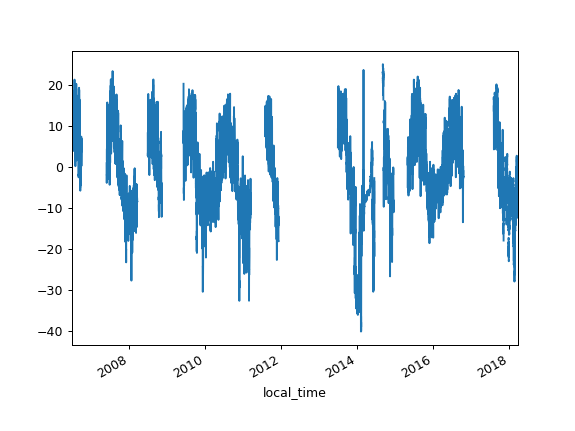

In [52]:
plt.figure()
dat.Tpassive1.plot()